
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
[Tip]: To execute the Python code in the code cell below, click on the cell to select it and press <kbd>Shift</kbd> + <kbd>Enter</kbd>.
</div>



# Exercise 2: Linear Regression for Housing Prices in Oregon

## Due Date: Sunday, 30.11.23

## Introduction

In this exercise, you will implement a *linear regression* and get to see it work on actual data. 

To run this notebook you should have the following Python packages installed:
* `numpy`
* `matplotlib`
* `sklearn`
* `pandas`

**The notebook contains 12 tasks for you to solve.**

Implement the Linear Regression in Python:

1. Computing the loss function $L(w)$ of linear regression
2. Normal-Equation: Closed-Form Solution to Linear Regression
3. Predict `y` using a single feature of `x`
4. Compute Polynomial Features

Bias vs Variance:

5. Effects of Adding Features
6. RMSE on test dataset
7. RMSE for Polynomial Regression 

Using SciKit-Learn:

8. Polynomial Regression in SciKit-Learn
9. Polynomial Regression in SciKit-Learn 2
10.  Bias (Underfitting) and Variance (Overfitting)
11.  High Degree Polynomials and Overfitting
12.  High Degree Polynomials and Overfitting in Lasso and Ridge Regressio

**Solving a task gives one point. Over all exercises you should obtain 50% of the points to pass.**


## Submission 

Hand in this assignment via Moodle.

## We will first install the required libraries

In [1]:
%load_ext autoreload
%autoreload 2

# plotting library written for this exercise
import wbi_teaching_applied_ml_utils as utils
print(utils.__version__)

# sklearn
import sklearn
print(sklearn.__version__)

0.2.2
1.3.0


If this gives an error, we might have to install the missing package first

In [2]:
# install utility functions
import sys
!{sys.executable} -m pip install --upgrade wbi_teaching_applied_ml_utils

# uncomment the below lines, if needed
# !{sys.executable} -m pip install scikit-learn

## Debugging

Here are some things to keep in mind throughout this exercise:

- Python array indices start from zero, not one. 

- There is an important distinction between python arrays (called `list` or `tuple`) and `numpy` arrays. You should use `numpy` arrays in all your computations. Vector/matrix operations work only with `numpy` arrays. Python lists do not support vector operations (you need to use for loops).

- If you are seeing many errors at runtime, inspect your matrix operations to make sure that you are adding and multiplying matrices of compatible dimensions. Printing the dimensions of `numpy` arrays using the `shape` property will help you debug.

- By default, `numpy` interprets math operators to be element-wise operators. If you want to do matrix multiplication, you need to use the `dot` function in `numpy`. For, example if `A` and `B` are two `numpy` matrices, then the matrix operation AB is `np.dot(A, B)`. Note that for 2-dimensional matrices or vectors (1-dimensional), this is also equivalent to `A@B` (requires python >= 3.5).

# Housing Prices in Oregon

In this part, you will use your implementation of linear regression to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

The file `ex1data2.txt` contains a training set of housing prices in Portland, Oregon. 
- The first column is the size of the house (in square feet).
- (The second column is the number of bedrooms, which we ignore for now)
- The third column is the price of the house (in 1000$). 

In [3]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from mpl_toolkits.mplot3d import Axes3D  # plot 3d surfaces
from sklearn.model_selection import train_test_split


# plotting library written for this exercise
from wbi_teaching_applied_ml_utils import Exercise2Utils as utils

We provide you with the code needed to load this data. The dataset is loaded from the data file into the variables `x` and `y` and split into train `x_train` and test `x_test` datasets:

In [4]:
# load data
x, y, m = utils.load_data_exercise_2()

# Create a test and train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

<hr>

# Plotting the Data

Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since we only use two properties to plot (size and price). Most other problems that you will encounter in real life are multi-dimensional and cannot be plotted on a 2d plot.

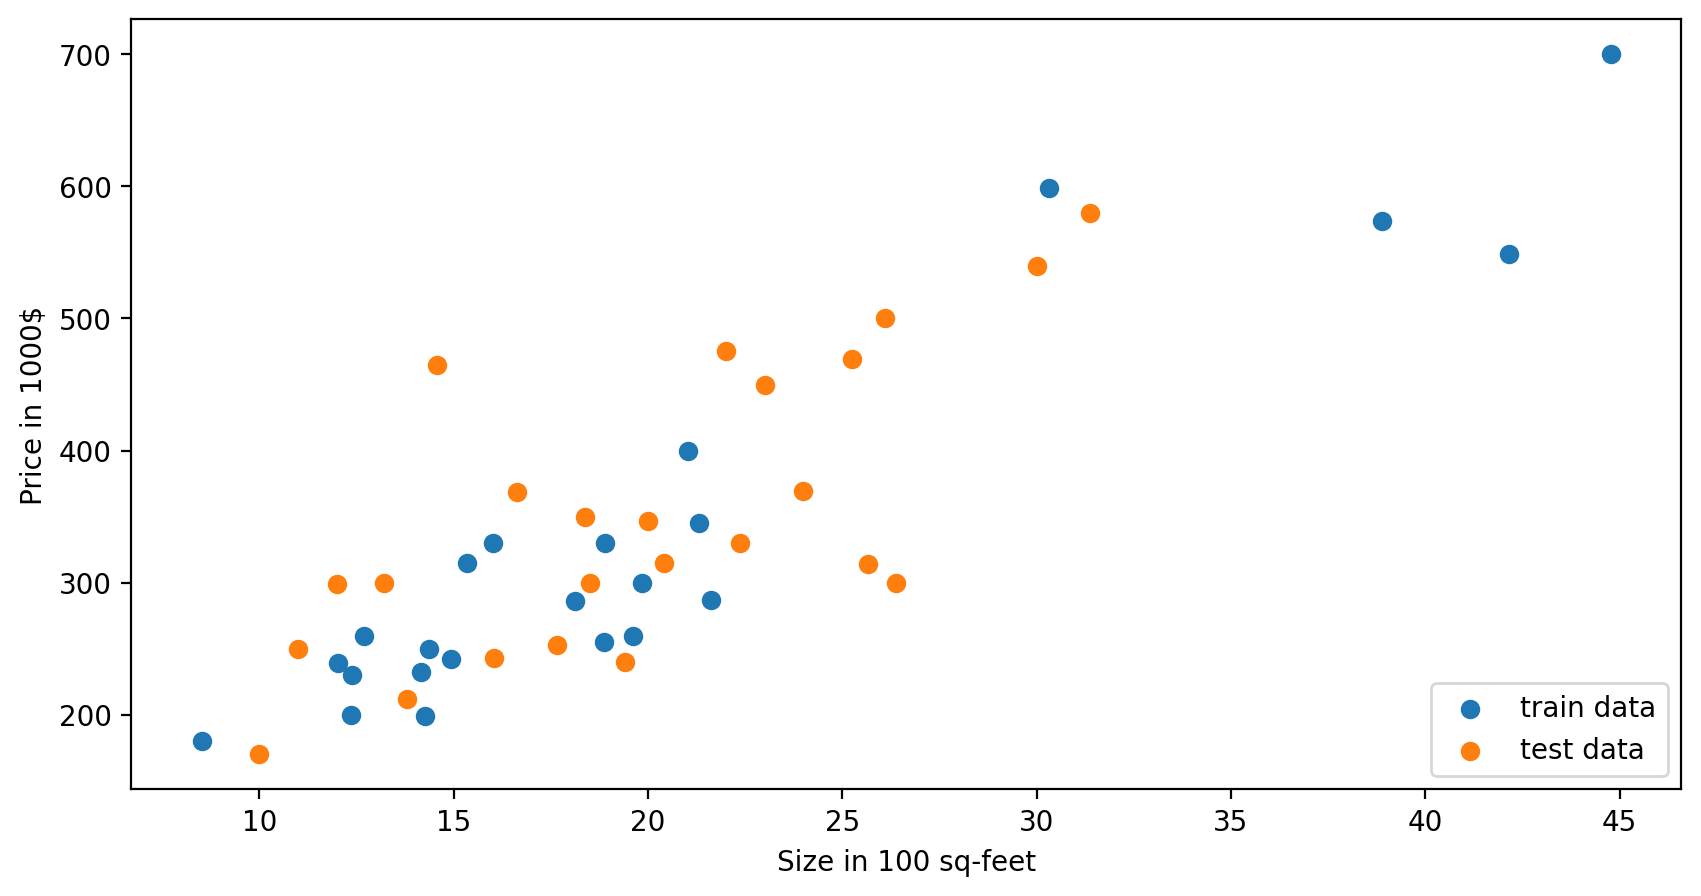

In [5]:
utils.plotData(x_train, y_train, x_test, y_test)

<hr>

# Linear Regression

The objective of linear regression is to minimize the loss function

$$ L(w) = \frac{1}{2m} \sum_{i=1}^m \left( h_{w}(x^{(i)}) - y^{(i)}\right)^2$$

where the hypothesis $h_w(x)$ is given by the linear model
$$ h_w(x) = w \cdot x$$

Recall that the parameters of your model are the $w_j$ weights. These are
the weights you will learn to minimize the loss function $L(w)$. 

## Design Matrix 
We store each example as a row in the the design matrix $X$. To take into account the intercept term ($w_0$), we add an additional first column to $X$ and set it to $1$. This allows us to treat $w_0$ as simply another 'feature' $x_0$.

In [6]:
# Create the design matrix by adding the all-1-column
X_train = np.concatenate([np.ones(shape=(y_train.size, 1)), x_train], axis=1)
X_test = np.concatenate([np.ones(shape=(y_test.size, 1)), x_test], axis=1)

In [7]:
# display first 10 data points 
import pandas as pd
df = pd.DataFrame(
        data=np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1), 
        columns=['$x_0$', '$x_1$', '$y$'])

df.head(10)

,$x_0$,$x_1$,$y$
0,1.0,44.78,699.900
1,1.0,19.85,299.900
2,1.0,12.36,199.900
3,1.0,18.11,285.900
4,1.0,12.68,259.900
5,1.0,21.32,345.000
6,1.0,14.27,198.999
7,1.0,42.15,549.000
8,1.0,16.00,329.900
9,1.0,18.90,329.999


<hr>

## Task 1: Computing the loss $L(w)$ function of linear regression

The cost or loss function of linear regression is defined as:
$$ L(w) = \frac{1}{2m} \sum_{i=1}^m \left( h_{w}(x^{(i)}) - y^{(i)}\right)^2$$

The vectorized formulation is:
$$ L(w) = \frac{1}{2m} ||Xw-y||^2$$

The cost $L_w(x)$ is also called **Mean Squared Error (MSE)**. 
If we take $L(w)^{1/2}$ we get the **Root MSE (RMSE)**

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Your first task is to complete the code for the cost function 
    
```python
    def computeCost(X, y, w)
``` 

Parameters:
- $X \in \mathbb{R}^{m \times  (n+1)}$ is the design matrix whose rows represent the examples from the training set and parameter 
- $y \in \mathbb{R}^{m}$ is a vector whose elements represent the target value at a given row of $X$.
- $w \in \mathbb{R}^{(n+1)}$ is the trained weight vector.


**Return**: $L(w)^{1/2}$: The **Root MSE (RMSE)**.
</div>

*Hint: Make use NumPy's (linear algbra) functions such as ```np.dot(), np.sum(), ...```*

In [8]:
def computeCost(X, y, w):
    """
    Instructions
    ------------
    Compute the root of the mean squared error (MSE) of a particular choice of w. 
    You should set L to this cost.
    """
    # initialize some useful values
    m = y.size  
    
    # You need to return the following variables correctly
    L = 0
    
    # YOUR CODE HERE
    L = np.sum(np.square(np.dot(X, w) - y)) / (2 * m)
    
    # return root MSE
    return np.sqrt(L)

In [9]:
w = np.array([0.0, 0.0])
L_train = computeCost(X_train, y_train, w)
L_test = computeCost(X_test, y_test, w)

assert isinstance(L_train, float)
assert isinstance(L_test, float)

assert abs(L_train - 252.24) <= 0.5
assert abs(L_test - 259.77) <= 0.5

print('With w = [{:.2f}, {:.2f}]'.format(*w),'\n Train RMSE computed = %.2f' % L_train)
print(' Expected cost value (approximately) 252.24')
print(' Test RMSE computed = %.2f' % L_test)
print(' Expected cost value (approximately) 259.77\n')

w = np.array([-1, 2])
L_train = computeCost(X_train, y_train, w)
L_test = computeCost(X_test, y_test, w)

assert abs(L_train - 221.79) <= 0.5
assert abs(L_test - 231.90) <= 0.5

print('With w = [{:.2f}, {:.2f}]'.format(*w),'\n Train RMSE computed = %.2f' % L_train)
print(' Expected cost value (approximately) 221.79')

print(' Test RMSE computed = %.2f' % L_test)
print(' Expected cost value (approximately) 231.90\n')

w = np.array([55.51159508, 13.58786551])
L_train = computeCost(X_train, y_train, w)
L_test = computeCost(X_test, y_test, w)

assert abs(L_train - 33.51) <= 0.5
assert abs(L_test - 55.88) <= 0.5

print('With w = [{:.2f}, {:.2f}]'.format(*w),'\n Train RMSE computed = %.2f' % L_train)
print(' Expected cost value (approximately) 33.51')

print(' Test RMSE computed = %.2f' % L_test)
print(' Expected cost value (approximately) 55.88\n')


With w = [0.00, 0.00] 
 Train RMSE computed = 252.24
 Expected cost value (approximately) 252.24
 Test RMSE computed = 259.77
 Expected cost value (approximately) 259.77

With w = [-1.00, 2.00] 
 Train RMSE computed = 221.79
 Expected cost value (approximately) 221.79
 Test RMSE computed = 231.90
 Expected cost value (approximately) 231.90

With w = [55.51, 13.59] 
 Train RMSE computed = 33.51
 Expected cost value (approximately) 33.51
 Test RMSE computed = 55.88
 Expected cost value (approximately) 55.88



<hr>

## Task 2: Normal-Equation: Closed-Form Solution to Linear Regression

The closed-form solution to linear regression is
$$ w = \left( X^T X\right)^{-1} (X^Ty) \in \mathbb{R}^{n+1}$$

This is also called the normal-equation.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Implement the following method

```python
def normalEqn(X, y):

```
that computes $w$ using the normal equation.

Parameters:
- $X \in \mathbb{R}^{m \times  (n+1)}$ is the design matrix whose rows represent the examples from the training set and parameter 
- $y \in \mathbb{R}^{m}$ is a vector whose elements represent the target value at a given row of $X$.

**Return**: $w \in \mathbb{R}^{(n+1)}$: the trained weight vector.

</div>

*Hint: Use the function `np.linalg.pinv` for computing the pseudo-inverse  $X^{-1}$ of any matrix $X$.*

In [10]:
def normalEqn(X, y):
    """
    Compute the closed-form solution to linear regression using the normal equations.
    You should set vector w to this solution.

    Hint
    ----
    Use the function `np.linalg.pinv` for computing the matrix pseudo-inverse.    
    """
    
    # You need to return the following variables correctly
    w = np.zeros(shape=X.shape[1])
    
    # YOUR CODE HERE
    w = np.dot(np.linalg.pinv(np.dot(np.transpose(X), X)), np.dot(np.transpose(X), y))

    return w

In [11]:
# Calculate the parameters from the normal equation
w = normalEqn(X_train, y_train)

assert isinstance(w, np.ndarray)
assert w.shape[0] == X_train.shape[1]
assert (abs(w - np.array([55.512, 13.588])) <= 0.5).all() 

print('w computed from the normal equation [{:.3f}, {:.3f}]:'.format(*w))
print(' Expected w (approximately) [55.512, 13.588]')


w computed from the normal equation [55.512, 13.588]:
 Expected w (approximately) [55.512, 13.588]


<hr>

## Plotting your Regression Line

We will now plot your optimal solution to the linear regression. 

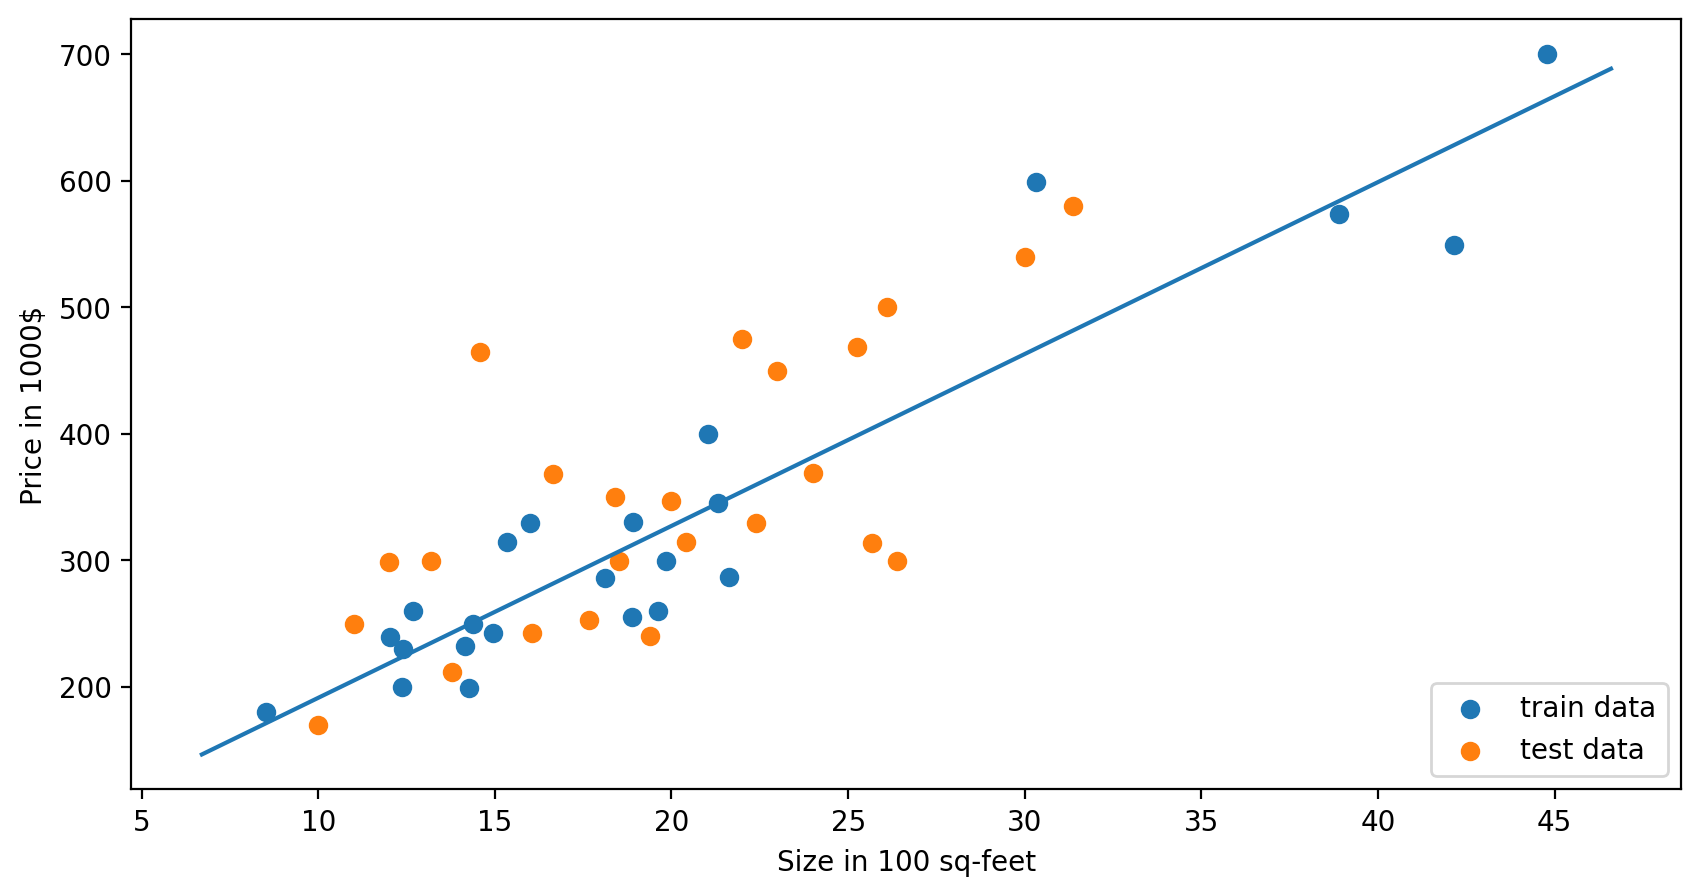

In [12]:
utils.plotLine(x_train, y_train, x_test, y_test, w)

<hr>

## Task 3: Predict `y` using a single feature of `x`

Now, once you have found $w$, use the hypothesis $$h_w(x)=w \cdot x$$ to make price predictions of houses.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Implement the following method based on the size in sq-feet.

```python
def predictPrice(x, y):

```
that predicts the price of a house based on the size and $h_w(x)$.

Parameters:
- $x \in \mathbb{R}^{(n+1)}$ the vector of a single house with an already added 1 for $x_0$.
- $w \in \mathbb{R}^{(n+1)}$ are the trained weight vectors.

**Return**: $y \in \mathbb{R}$: The estimated price of the house

</div>

*Hint: Use the linear algebra routines in NumPy.*

In [13]:
def predictPrice(x, w):
    """
    Compute the predicted value by the linear regression line. 
    You should set y to this value.
    """
    
    # You need to return the following variables correctly
    y = 0
    
    # YOUR CODE HERE
    y = np.dot(x, w)
    
    return y

In [14]:
# Estimate the price of a 1650 sq-ft
size = 16.5
price = predictPrice(np.array([1, size]), w)

assert isinstance(price, float)
assert abs(price - 280) <= 0.5


print('Predicted price (in 1000$) of a {:.0f}'.format(size*100),'sq-ft house: ${:.0f}'.format(price))

# Estimate the price of a 0 sq-ft
size = 1
price = predictPrice(np.array([1, size]), w)

assert abs(price - 69) <= 0.5


print('Predicted price (in 1000$) of a {:.0f}'.format(size*100),'sq-ft house: ${:.0f}'.format(price))


Predicted price (in 1000$) of a 1650 sq-ft house: $280
Predicted price (in 1000$) of a 100 sq-ft house: $69


<hr>

## Visualizing Loss Function $L(w)$

To understand the loss function $L(w)$ better, we will now plot the cost over a 2-dimensional grid of $w_0$ and $w_1$ values. The purpose of these graphs is to understand how $L(w)$ varies with changes in $w_0$ and $w_1$. The cost function $L(w)$ is bowl-shaped and has a global minimum. Its minimum is the optimal point for $w_0$ and $w_1$.

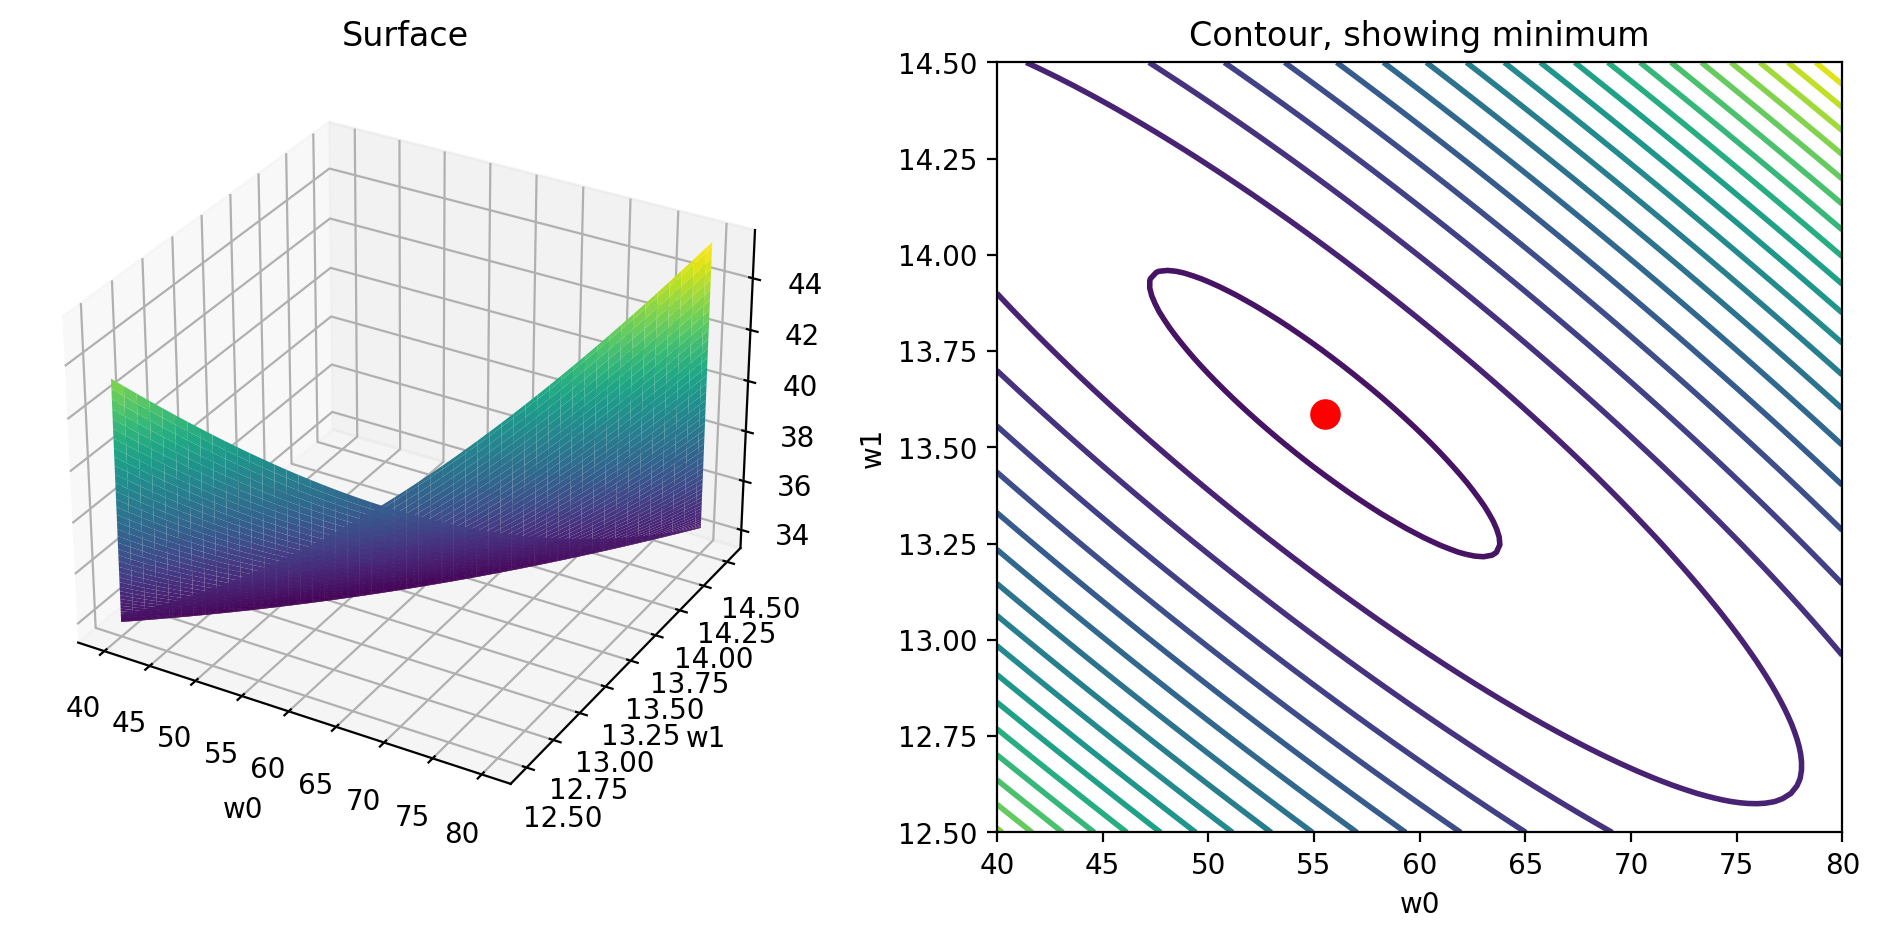

In [15]:
# grid over which we will calculate L
w0_vals = np.linspace(40, 80, 100)
w1_vals = np.linspace(12.5, 14.5, 100)

# initialize L_vals to a matrix of 0's
L_vals = np.zeros((w0_vals.shape[0], w1_vals.shape[0]))
    
# compute costs
for i, w0 in enumerate(w0_vals):
    for j, w1 in enumerate(w1_vals):
        L_vals[i, j] = computeCost(X_train, y_train, [w0, w1])
            
# Because of the way meshgrids work in the surf command, we need to
# transpose L_vals before calling surf, or else the axes will be flipped
L_vals = L_vals.T
                
utils.plotLossFunction(X_train, y_train, w0_vals, w1_vals, L_vals, w)

<hr>

# Multivariate Linear Regression using Polynomial Features

In this part, you will use your implementation of linear regression to predict the prices of houses using polynomial regression.

In [16]:
# Load data
x, y, m = utils.load_data_exercise_2()

# Create the Design Matrix
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=3)
X_train = np.concatenate([np.ones((y_train.size, 1)), x_train], axis=1)
X_test = np.concatenate([np.ones((y_test.size, 1)), x_test], axis=1)

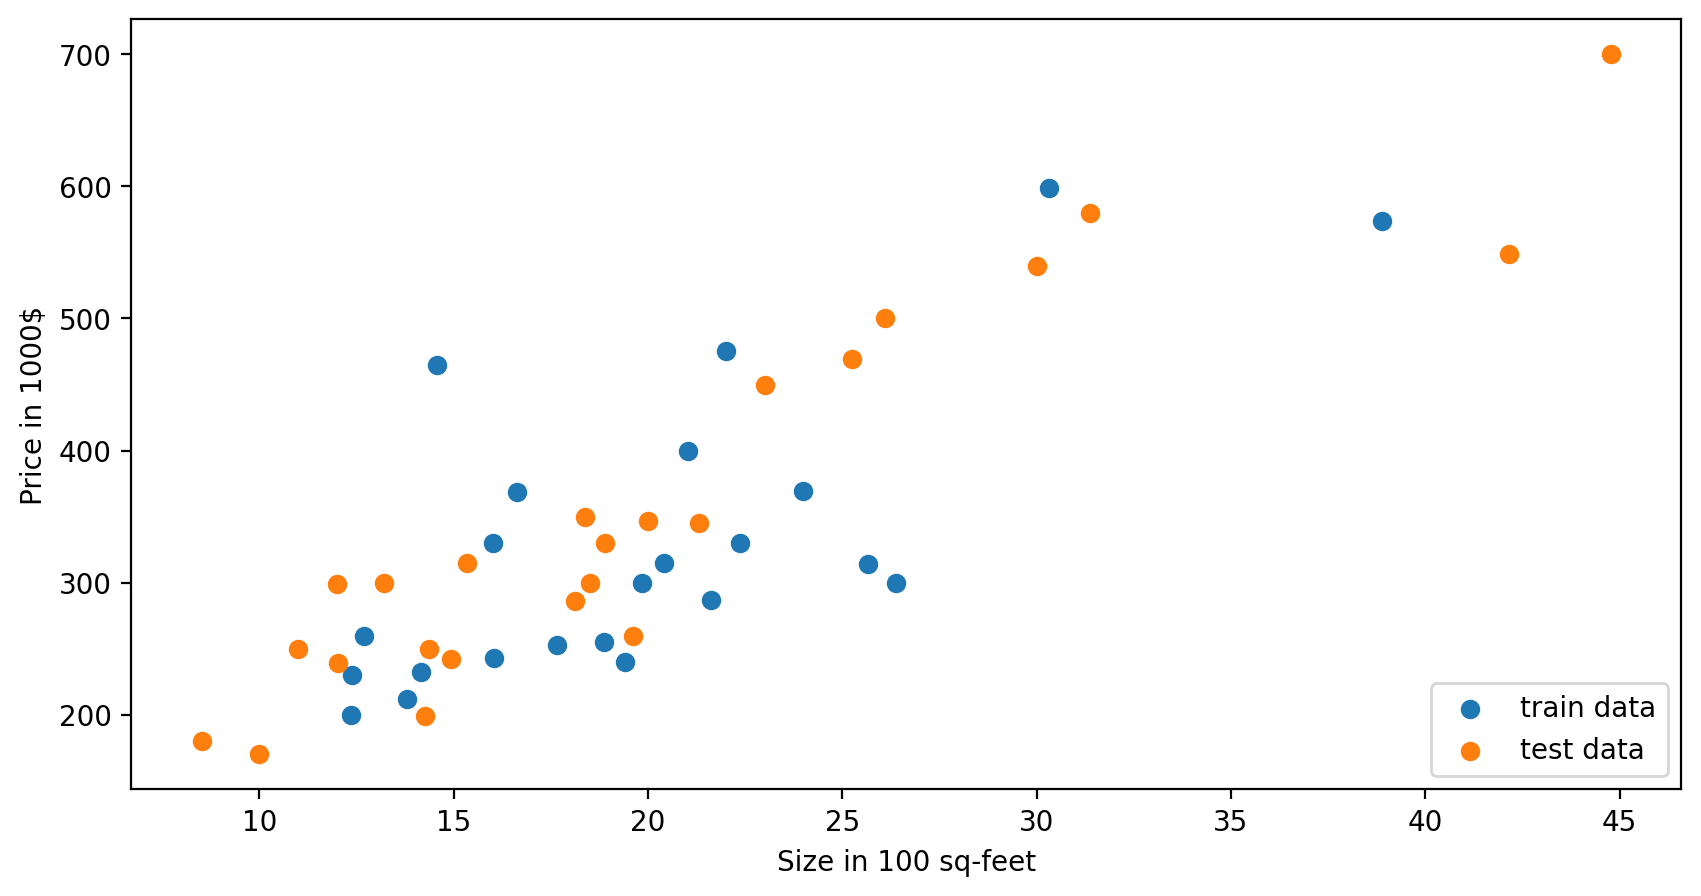

In [17]:
utils.plotData(x_train, y_train, x_test, y_test)

<hr>

## Task 4: Compute Polynomial Features

One way to fit the data better is to create more features from each sample. We will map $x_1$ up to some power.

- The second power would be all features whose combined power is at most $2$:
$$ \text{mapPolynomialFeatures}(x, 2) = \begin{bmatrix} 1 & x_1 & x_1^2 \end{bmatrix} $$
- The third power would be all features whose combined power is at most $3$:
$$ \text{mapPolynomialFeatures}(x, 3) = \begin{bmatrix} 1 & x_1 & x_1^2 & x^3 \end{bmatrix} $$
and so on.


<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Implement the method 

```python
def mapPolynomialFeatures(X1, degree)
```

Parameters:
- $X1 \in \mathbb{R}^{m \times 1}$: input only a single column of features

**Return**: out: a matrix $M \in \mathbb{R}^{m \times (degree+1)}$ with new polynomial featues as new columns
</div>

*Hint: You can use out.append() to append columns to the result*



In [18]:
def mapPolynomialFeatures(X1, degree=3):    
    """
    Maps the input feature to the degree of polynomial.        
    
    X1 is a single column of featues and not the design matrix!    
    """
    # You need to return the following variable correctly
    ## initially: all ones column
    out = [np.ones(X1.shape[0])]
    
    # YOUR CODE HERE
    for i in range(1, degree + 1):
        out.append(np.power(X1, i))
    
    return np.stack(out, axis=1)

In [19]:
X_poly_train = mapPolynomialFeatures(X_train[:, 1], degree=3)

assert X_poly_train.shape == (23,4)
print('Expected dimensions: (23,4)')

X_poly_train = mapPolynomialFeatures(X_train[:, 1], degree=4)
assert X_poly_train.shape == (23,5)
print('Expected dimensions: (23,5)\n')

X_poly = mapPolynomialFeatures(np.array([2]), degree=2)

assert X_poly.shape == (1,3)
assert (abs(X_poly[0] - np.array([1,2,4])) <= 0.5).all() 

print('Expected dimensions: (1,3)')
print('Expected features: [1,2,4]\n')

X_poly = mapPolynomialFeatures(np.array([3]), degree=3)

assert X_poly.shape == (1,4)
assert (abs(X_poly[0] - np.array([1,3,9,27])) <= 0.5).all() 

print('Expected dimensions: (1,4)')
print('Expected features: [1,3,9,27]')


Expected dimensions: (23,4)
Expected dimensions: (23,5)

Expected dimensions: (1,3)
Expected features: [1,2,4]

Expected dimensions: (1,4)
Expected features: [1,3,9,27]


Lets compare the solutions of the original data <code>X_train</code> and the new data <code>X_poly_train</code>. We notice that the RMSE decreased when the number of (polynomial) features increased:

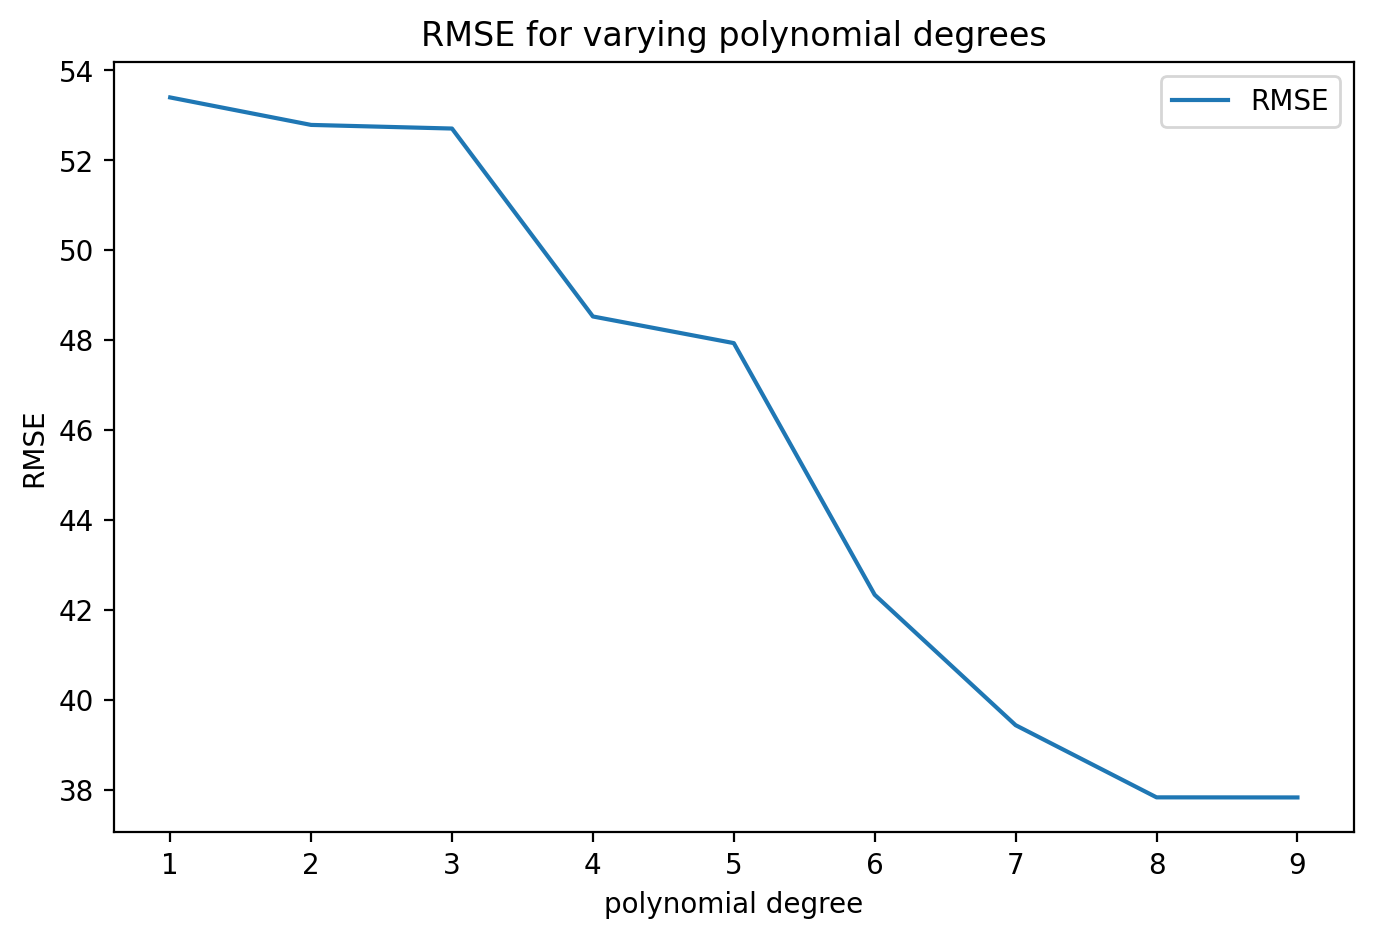

In [20]:
# scale to avoid a number overflow
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train[:, 1])

Ls_poly_train = []
polys = np.arange(1, 10)

for degree in polys:
    # train using polynomial features
    X_poly_train = mapPolynomialFeatures(X_scaled, degree=degree)
    w_poly = normalEqn(X_poly_train, y_train);
    Ls_poly_train.append(computeCost(X_poly_train, y_train, w_poly))

utils.plot_polynomial_rmse(polys, Ls_poly_train)

<hr>

## Task 5: Effects of Adding Features
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
With every added feature:
    
- We learned that the overall Euclidean distance *increases* between any two vectors.
- But for linear regression the opposite happens: with every added feature, the RMSE on the train data *decreases*. 
    
**Explain this briefly.**
</div>

By adding features and weights the model adapts more to the training data and therefore performs well on the training data leading to a lower RMSE. This can lead to overfitting because generalization will be harder for the model.

<hr>

## Task 6: RMSE on test data set
Now, you are to compute the RMSE using polynomial features on the **test dataset**.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Implement the following two methods

```python
def testRMSEWithPoly (X_test, y_test, w_poly, degree):

```
which compute the cost (RMSE) of polynomial regression on the **test dataset**.

```python
def testRMSE (X_test, y_test, w):

```
which compute the cost (RMSE) of linear regression on the **test dataset**.

Parameters:
- $\textbf{X\_test} \in \mathbb{R}^{m \times (n+1)}$: the design matrix of the test data
- $\textbf{y\_test} \in \mathbb{R}^{m}$: is a vector whose each elements represent the value at a given row of $X_{test}$.
- $\textbf{w\_poly} \in \mathbb{R}^{(degree+1)}$: the trained weight vectors.
- $\textbf{degree} \in \mathbb{R}$: the degree of the polynomial 

**Return**: rmse: The estimated price of the house
</div>



In [21]:
def testRMSEWithPoly (X_test, y_test, w_poly, degree):
    """
    Instructions
    ------------
    Compute the root of the root mean squared error (RMSE) 
    of polynomial regression on the test dataset.
    """
    
    # initialize some useful values
    X1_test = X_test[:, 1] # use size feature

    # You need to return the following variables correctly
    rmse = 0 
    
    # YOUR CODE HERE
    X_poly_test = mapPolynomialFeatures(X1_test, degree)
    rmse = computeCost(X_poly_test, y_test, w_poly)
    
    return rmse

In [22]:
def testRMSE (X_test, y_test, w):
    """
    Instructions
    ------------
    Compute the root of the root mean squared error (RMSE) 
    of linear regression on the test dataset.
    """    
    # You need to return the following variables correctly
    rmse = 0
    
    # YOUR CODE HERE
    rmse = computeCost(X_test, y_test, w)
    
    return rmse

In [23]:
X_poly_train = mapPolynomialFeatures(X_train[:, 1], degree=5)
w_poly = normalEqn(X_poly_train, y_train)
rmseTestPoly = testRMSEWithPoly(X_test, y_test, w_poly, 5)

assert isinstance(rmseTestPoly, float)
assert abs(rmseTestPoly - 170.90) <= 0.5


print ("RMSE Test 5-degree polynomial: {:10.2f}".format(rmseTestPoly))

w = normalEqn(X_train, y_train)
rmseTest = testRMSE(X_test, y_test, w)

assert abs(rmseTest - 38.55) <= 0.5


print ("RMSE Test original features:   {:10.2f}".format(rmseTest))


RMSE Test 5-degree polynomial:     170.90
RMSE Test original features:        38.55


Lets plot the 2nd, 3rd and 4th degree polynomial for only one dimension (size):

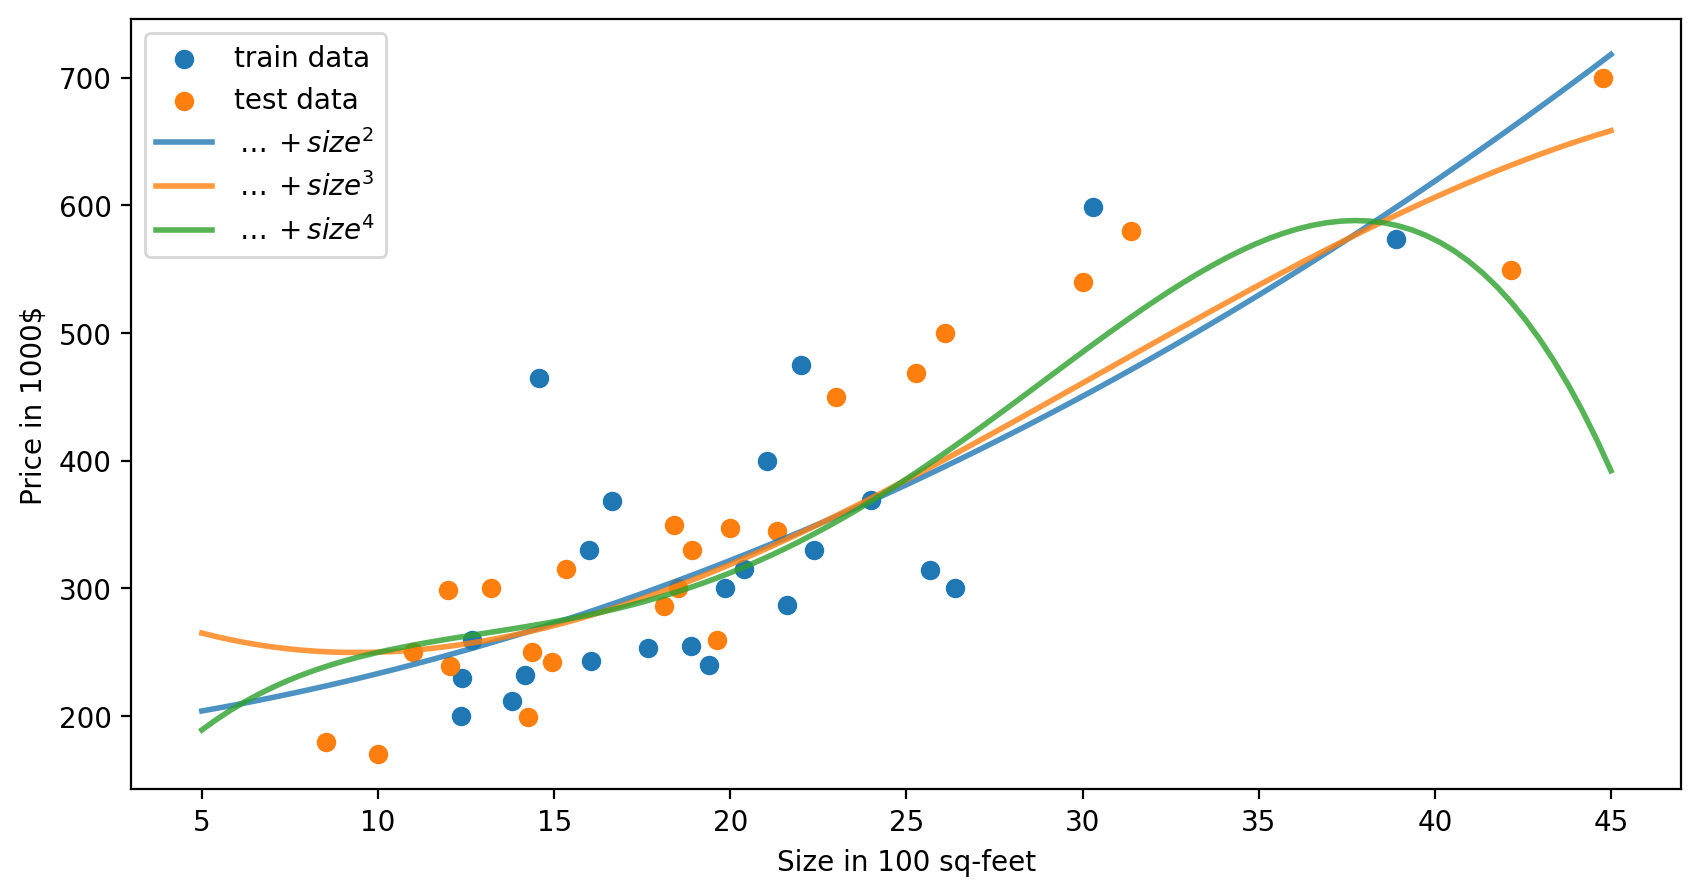

In [24]:
def plotPolyLine(x_train, y_train, x_test, y_test, w, degree):            
    utils.plotData(x_train, y_train, x_test, y_test)
        
    # Regression Polynom
    for degree in [2,3,4] :
        X_poly = mapPolynomialFeatures(x_train[:,0], degree)    
        w_poly = normalEqn(X_poly, y_train);
        x1 = np.float32(np.linspace(5, 45, 100))
        x2 = np.float32(np.linspace(1, 1, 100))
        polys = mapPolynomialFeatures(x1, degree)
        y_vals = predictPrice(polys, w_poly)        
        plt.plot(x1, y_vals, alpha=0.8, lw=2, 
                 label="$\dots+size^"+str(degree)+"$")
    
    plt.legend()
        
    
plotPolyLine(x_train, y_train, x_test, y_test, w, 4)

<hr>

## Task 7: RMSE for Polynomial Regression 

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
    Explain your observations of the RMSE on the <b>test data</b> and the plotted polynomials. What do you observe for higher degree polynomials in terms of bias (underfitting) and variance (overfitting)?
</div>

In the beginning the polynoms are very close to each other. After a certain x-value the polynoms start to spread more, which means higher variance between the polynoms, which you can see best on the last data point. Also the higher degree polynom fits better on test data, which means lower bias, except the last data point. 

<hr>

# SciKit-Learn: Linear-Regression

To make things a little even easier, we will now use the SciKit functionality in `sklearn.linear_model`.


First, run the following block to set up the variables needed for later sections.

In [25]:
# Load data
x, y, m = utils.load_data_exercise_2()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

## Linear Regression in SciKit-Learn
Here we define a **linear regression** <code>LinearRegression</code> that takes our `X_train` and `y_train`. 

*Note: We do not have to create the design matrix aynmore, as this is implicitly done my SciKit-learn.*

In [26]:
from sklearn.linear_model import LinearRegression

# Train a linear regression model
regr = LinearRegression()
regr.fit(X_train, y_train)

# Make predictions using the model
y_pred = regr.predict(X_test)

## MSE and RMSE in SciKit-Learn
To compute the mean squared error, we use the utility functions <code>sklearn.metrics.mean_squared_error</code>

In [27]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

print ("Mean squared error (MSE):       {:10.2f}".format(mse))
print ("Root mean squared error (RMSE): {:10.2f}".format(np.sqrt(mse)))

Mean squared error (MSE):          6245.15
Root mean squared error (RMSE):      79.03


## Polynomial Regression in SciKit-Learn
To add polynomial features we use <code>sklearn.preprocessing.PolynomialFeatures</code> and apply it to our datasets. This results in polynomial features of <code>degree</code>.

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train)

regrPoly = LinearRegression()
_ = regrPoly.fit(X_poly_train, y_train)

Finally, we can plot the results.

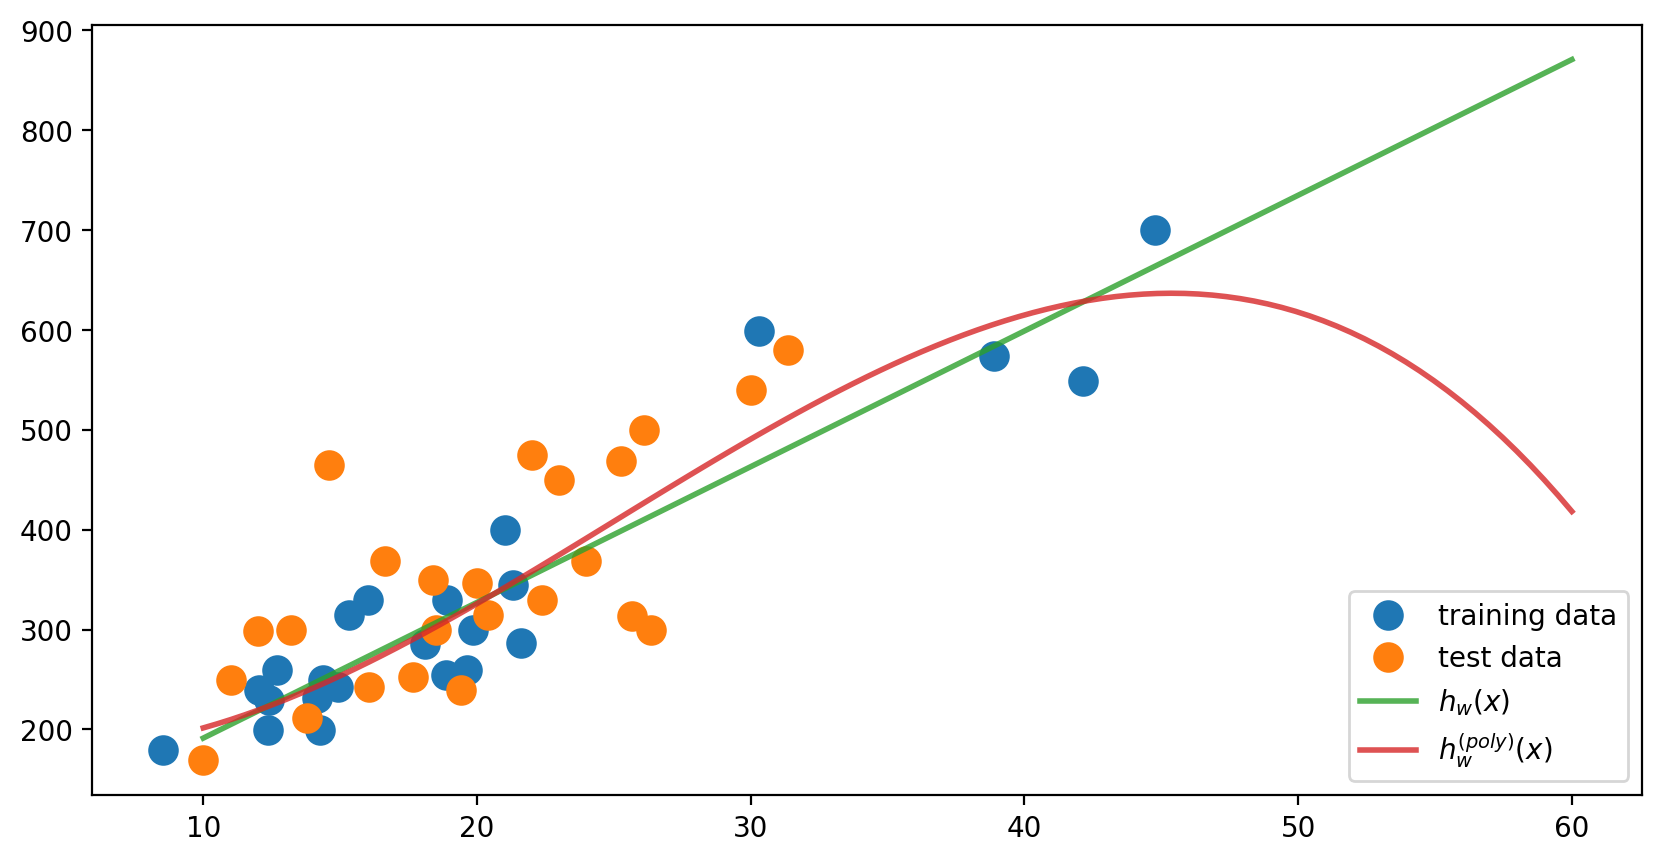

In [29]:
# Plot data points as well as predictions
x_interval = np.linspace(10,60,100)[:,None]

plt.figure(figsize=(10,5))
plt.plot(X_train, y_train, 'o', label='training data', markersize=10)
plt.plot(X_test, y_test, 'o', label='test data', markersize=10)

# linear reg
lin_pred = regr.predict(x_interval)

# polynomial reg
transformed = poly.transform(x_interval) # make it a 2d array for ease of use
poly_pred = regrPoly.predict(transformed)

plt.plot(x_interval, lin_pred, alpha=0.8, lw=2, label='$h_w(x)$')
plt.plot(x_interval, poly_pred, alpha=0.8, lw=2, label='$h^{(poly)}_w(x)$')
_ = plt.legend(loc=4)

<hr>

## Task 8: Polynomial Regression in SciKit-Learn

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Implement the following method

```python
def task8(X_train, y_train):
```
that fits a polynomial LinearRegression model on the <b>training data</b> `X_train` for degrees `degree=[1, 3, 6, 9]`.

Parameters:
- $\textbf{X\_train} \in \mathbb{R}^{m \times n}$: the train data (without bias column)
- $\textbf{y\_train} \in \mathbb{R}^{m}$: is a vector whose each elements represent the value at a given row of X_train.

**Return**: A tuple: `(x_interval, predictions)` with `predictions` of shape (4,100)
</div>


*Hint:  You have to make 100 predictions using x_interval for each model.*

<!--
![image.png](attachment:image.png)

The figure above shows what the fitted models plotted on top of the original data (using `task8(...)`) should look like.
-->

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

degree = [1,3,6,9]

def task8(X_train, y_train):
    """
    Instructions
    ------------
    Train Polynomials of degree [1,3,6,9].
    For each trained model, make predictions in the range of x_interval.
    Return: This function should return a tuple (x_interval, predictions)
    """  
        
    # initialize some useful values
    x_interval = np.linspace(10,60,100)
    x_interval = x_interval[:,None] # make it a 2-dim array for ease of use with predict

    # You need to return the following variables correctly
    predictions = np.zeros((len(degree),100))
    
    for i, deg in enumerate(degree):
        # YOUR CODE HERE
        poly = PolynomialFeatures(degree=deg)
        X_poly_train = poly.fit_transform(X_train)
        model = LinearRegression()
        model.fit(X_poly_train, y_train)
        x_interval_poly = poly.transform(x_interval)
        predictions[i, :] = model.predict(x_interval_poly)
        
    return (x_interval, predictions)

In [31]:
x_interval, result = task8(X_train, y_train)

assert isinstance(x_interval, np.ndarray)
assert isinstance(result, np.ndarray)

assert x_interval.shape == (100,1)
assert result.shape == (4,100)

for i, value in zip(np.arange(4), [191.39, 201.60, 194.32, 194.97]):
    assert abs(result[i][0] - value) <= 1.0
    print(f"The actual first result value for degree {[1,3,6,9][i]} is {np.round(result[i][0],2)}")
    print(f" The expected first result value is (approximately): {value}\n")


The actual first result value for degree 1 is 191.39
 The expected first result value is (approximately): 191.39

The actual first result value for degree 3 is 201.6
 The expected first result value is (approximately): 201.6

The actual first result value for degree 6 is 194.32
 The expected first result value is (approximately): 194.32

The actual first result value for degree 9 is 194.97
 The expected first result value is (approximately): 194.97



Now lets plot the result of different polynomial degrees:

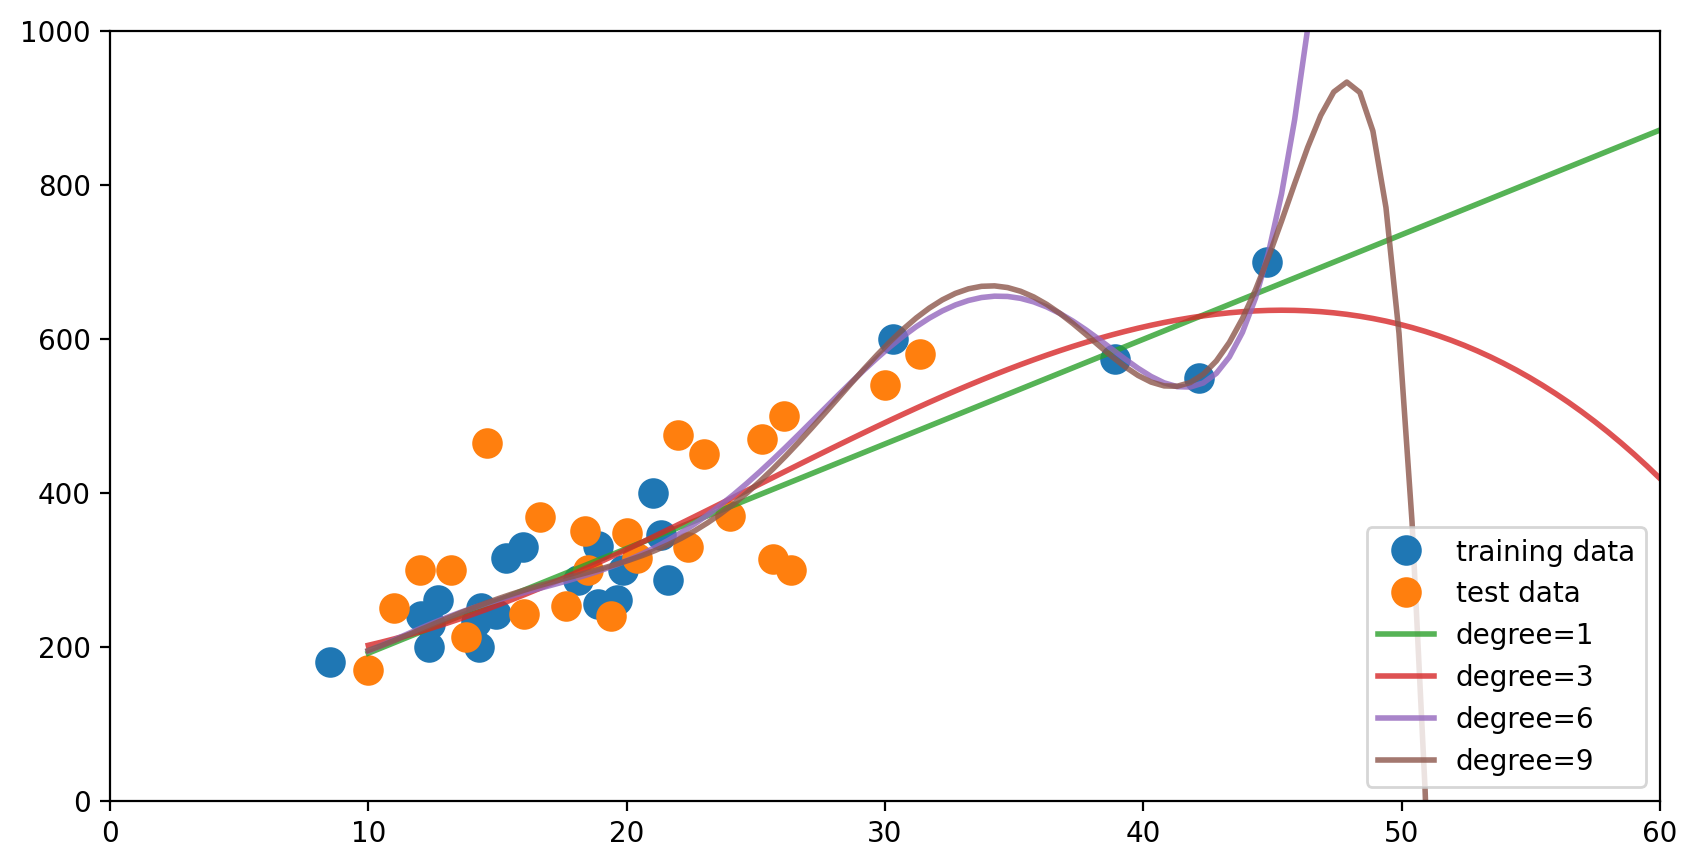

In [32]:
x_interval, result = task8(X_train, y_train)
utils.plot_one(X_train, y_train, X_test, y_test, result, x_interval, degree)

<hr>

## Task 9: Polynomial Regression in SciKit-Learn 2

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Write a function 

```python
def task9(X_train, y_train, X_test, y_test)
```

that fits a `polynomial LinearRegression` model on the training data `X_train` for degrees 0 through 15. For each model compute the MSE on the training data and the MSE on the test data.

Parameters:
- $\textbf{X\_train} \in \mathbb{R}^{m \times n}$: the train data (without bias column)
- $\textbf{y\_train} \in \mathbb{R}^{m}$: is a vector whose each elements represent the value at a given row of X_train.
- $\textbf{X\_test} \in \mathbb{R}^{m \times n}$: the test data (without bias column)
- $\textbf{y\_test} \in \mathbb{R}^{m}$: is a vector whose each elements represent the value at a given row of X_test.

**Return**: A tuple: (mse_train, mse_test), where mse_train and mse_test contain entries for all `degrees`.
</div>

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

degrees = np.arange(16)

def task9(X_train, y_train, X_test, y_test):
    """
    Instructions
    ------------
    Fits a polynomial LinearRegression model on the 
    training data `X_train` for degrees stored in `degrees`. 
    For each model compute the MSE on the training data 
    and the MSE on the test data.
    """  
      
    # You need to return the following variables correctly        
    mse_train = np.zeros(len(degrees))
    mse_test = np.zeros(len(degrees))
    
    # YOUR CODE HERE
    for i, deg in enumerate(degrees):
        poly = PolynomialFeatures(degree=deg)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
        model = LinearRegression()
        model.fit(X_poly_train, y_train)
        y_pred_train = model.predict(X_poly_train)
        y_pred_test = model.predict(X_poly_test)
        mse_train[i] = mean_squared_error(y_train, y_pred_train)
        mse_test[i] = mean_squared_error(y_test, y_pred_test)

    return mse_train, mse_test

In [34]:
mse_train, mse_test = task9(X_train, y_train, X_test, y_test)

assert mse_train.shape == (len(degrees),)
assert abs(mse_train[2] - 2241.15 ) <= 1

print('Train MSE computed for degree 2 is {:.2f}'.format(mse_train[2]))
print('Expected Train MSE (approximately) 2241.15\n')

assert mse_test.shape == (len(degrees),)
assert abs(mse_test[2] - 6220.77 ) <= 1

print('TEST MSE computed for degree 2 is {:.2f}'.format(mse_test[2]))
print('Expected Test MSE (approximately) 6220.77\n')


Train MSE computed for degree 2 is 2241.15
Expected Train MSE (approximately) 2241.15

TEST MSE computed for degree 2 is 6220.77
Expected Test MSE (approximately) 6220.77



<hr>

## Task 10: Bias (Underfitting) and Variance (Overfitting)

Based on the **RMSE** scores from question 2 (degree levels 0 through 9) we will plot the train and test MSE scores.

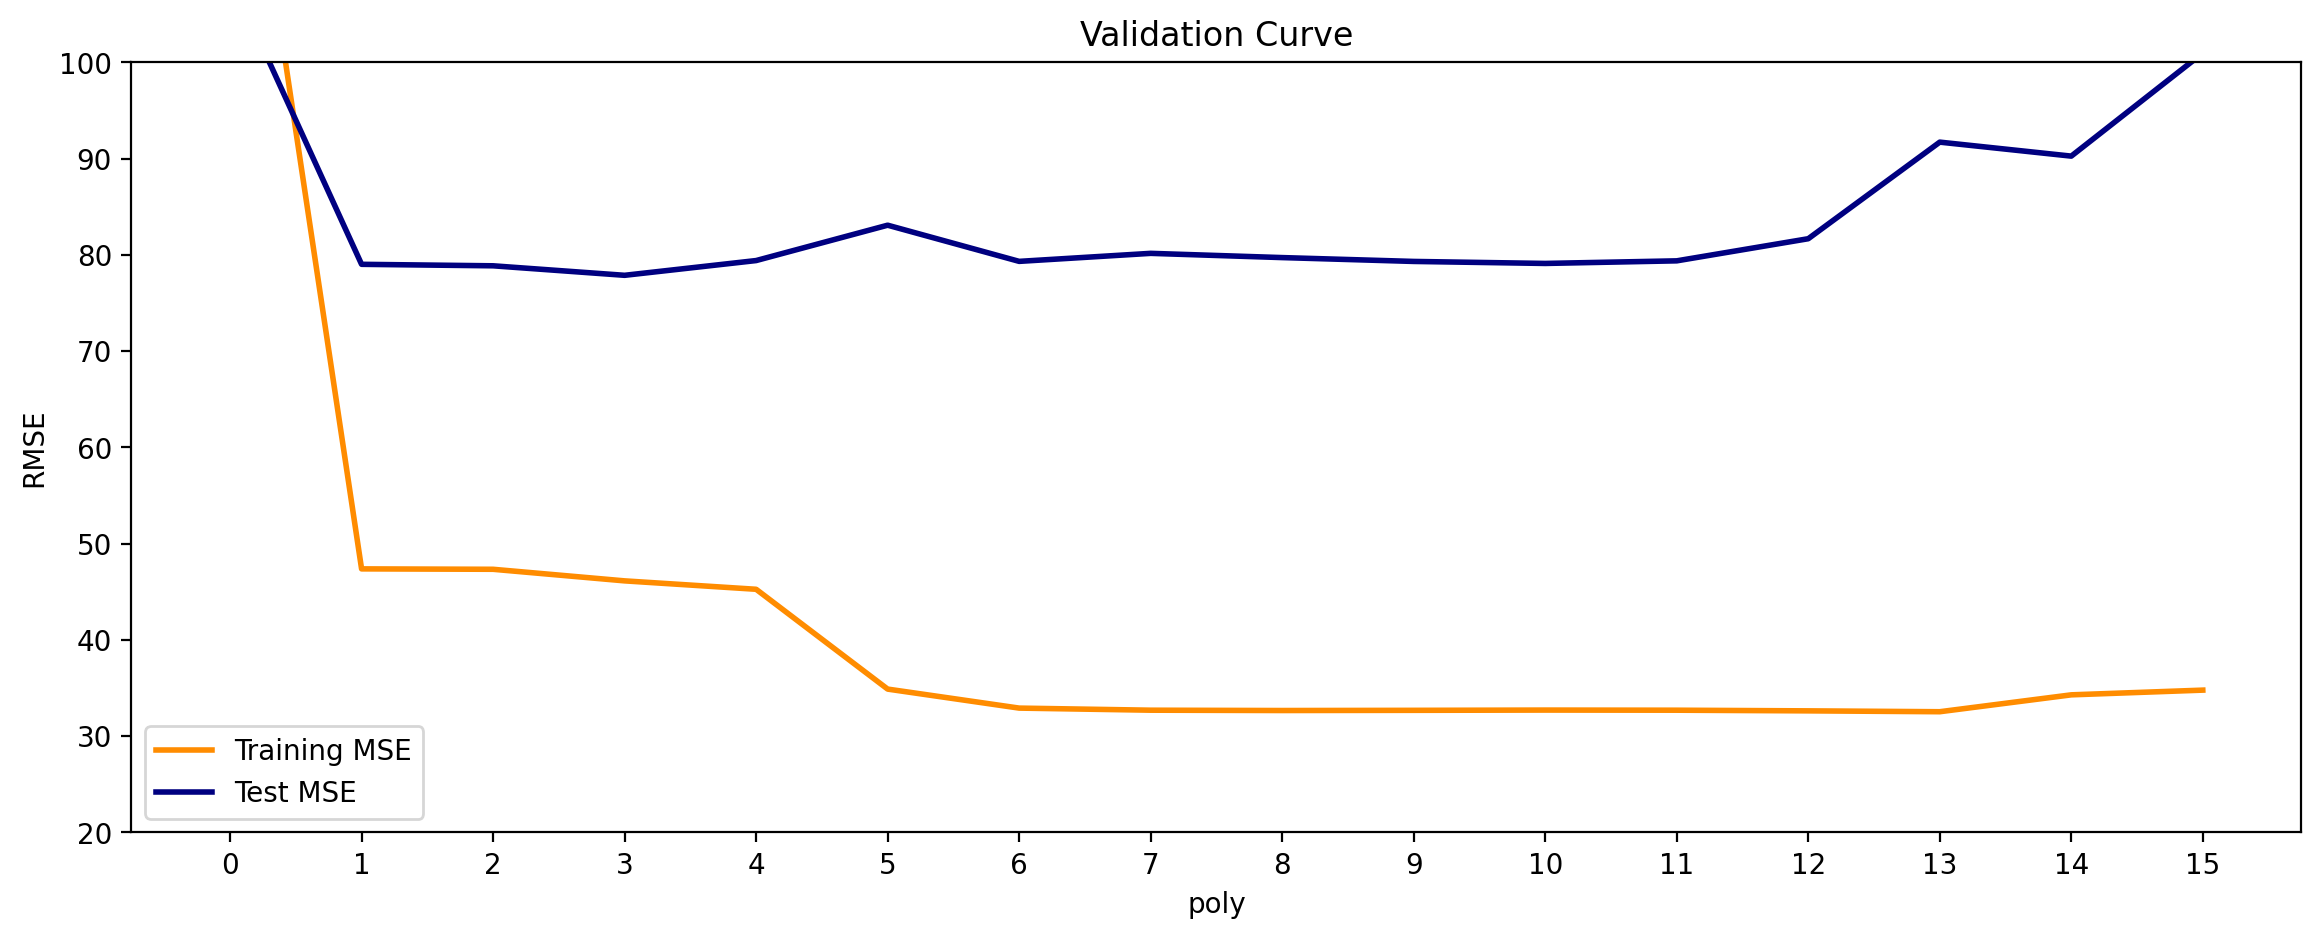

In [35]:
mse_train, mse_test = task9(X_train, y_train, X_test, y_test)
utils.plot_validation_curve(mse_train, mse_test, degrees)

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Based on this result:
    
- What polynomial degree level corresponds to a model that is underfitting (high bias)? 
- What degree level corresponds to a model that is overfitting (high variance)? 
- What choice of degree level would provide a model with good generalization performance on this dataset? 
</div>
Note: there may be multiple correct solutions to this question.

underfitting: deg = 1
overfitting: deg = 15
good generalization performance: deg = 6 to 11

<hr>

## Task 11: High Degree Polynomials and Overfitting

Training models on high degree polynomial features can result in overly complex models that overfit, so we often use regularized versions of the model to constrain model complexity, as we saw with Ridge and Lasso regression in the lecture.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Write a function  
    
```python
    def task11(X_train_poly, y_train, X_test_poly, y_test):

```

that trains three models: 
- a Polynomial non-regularized LinearRegression model `sklearn.linear_model.LinearRegression` with default parameters,
- a Polynomial regularized Lasso Regression model `sklearn.linear_model.Lasso`
with parameters `alpha=1`, `max_iter=1000, random_state=1379`, and
- a Polynomial regularized Ridge Regression model `sklearn.linear_model.Ridge` with parameters `alpha=1`, `max_iter=1000` , `random_state=1379`
on polynomial features of degree 12. 

Parameters:
- X_poly_train: the transformed polynomial train data
- y_train: is a vector whose each elements represent the value at a given row of X_train.
- X_test_poly: the the transformed polynomial test data (without bias column)
- y_test: is a vector whose each elements represent the value at a given row of X_test.


Return:
- This function should return one tuple 
`(X_test_pred_reg, X_test_pred_lasso, X_test_pred_ridge)`
- These are the predictions for all model's **test sets**.
</div>

*Hint: Make use of `Lasso, Ridge and LinearRegression` in SciKit-Learn*

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

alpha=1
max_iter = 10000
random_state = 1379
degree = 5

def task11(X_train_poly, y_train, X_test_poly, y_test):    
    """
    Instructions
    ------------
    Fits three models and return the predictions on the test data for each model
    """  
      
    # You need to return the following variables correctly
    X_test_pred_reg = 0
    X_test_pred_lasso = 0
    X_test_pred_ridge = 0
    
    # YOUR CODE HERE
    model_reg = LinearRegression()
    model_reg.fit(X_train_poly, y_train)
    X_test_pred_reg = model_reg.predict(X_test_poly)
    
    model_lasso = Lasso(alpha=alpha, max_iter=max_iter, random_state=random_state)
    model_lasso.fit(X_train_poly, y_train)
    X_test_pred_lasso = model_lasso.predict(X_test_poly)
    
    model_ridge = Ridge(alpha=alpha, max_iter=max_iter, random_state=random_state)
    model_ridge.fit(X_train_poly, y_train)
    X_test_pred_ridge = model_ridge.predict(X_test_poly)

    return X_test_pred_reg, X_test_pred_lasso, X_test_pred_ridge

In [37]:
scaler = StandardScaler(with_std=True)
poly = PolynomialFeatures(degree=degree)

X_train_poly = scaler.fit_transform(poly.fit_transform(X_train))
X_test_poly = scaler.transform(poly.transform(X_test))

X_test_pred_reg, X_test_pred_lasso, X_test_pred_ridge  \
    = task11(X_train_poly, y_train, X_test_poly, y_test)

mseRegression = mean_squared_error(X_test_pred_reg, y_test)
print('LinearRegression MSE', mseRegression)
print('Expected MSE (approximately) 6904\n')
assert abs(mseRegression -  6904) <= 5

mseLasso = mean_squared_error(X_test_pred_lasso, y_test)
print('Lasso MSE', mseLasso)
print('Expected MSE (approximately) 6241\n')
assert abs(mseLasso -  6241) <= 10


mseRidge = mean_squared_error(X_test_pred_ridge, y_test)
print('Ridge MSE', mseRidge)
print('Expected MSE (approximately) 6327\n')
assert abs(mseRidge -  6327) <= 10



LinearRegression MSE 6904.065507780801
Expected MSE (approximately) 6904

Lasso MSE 6241.535004571564
Expected MSE (approximately) 6241

Ridge MSE 6327.343794197354
Expected MSE (approximately) 6327



Finally, we plot the result:

In [38]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

x_interval = np.linspace(0,80,100)

def comparisonPlot(regr, poly, degree, title):
    # Your code here
    result = np.zeros((1,100))
    X_poly = poly.fit_transform(X_train)
    regr.fit(X_poly, y_train)    
    result[0,:] = regr.predict(poly.transform(x_interval[:,None]))        
    utils.plot_one(X_train, y_train, X_test, y_test, result, x_interval[:,None], [degree])
    plt.title(title)

@interact
def compare(degree=range(1,20), alpha=[0.1,0.5,1,1.5,5,10]) :
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    result = comparisonPlot(
        make_pipeline(StandardScaler(), LinearRegression()), poly, degree, "Linear Regression")
    result2 = comparisonPlot(
        make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter = 5000, random_state=random_state)), poly, degree, "Lasso Regression")
    result3 = comparisonPlot(
        make_pipeline(StandardScaler(), Ridge(alpha=alpha, max_iter = 5000, random_state=random_state)), poly, degree, "Ridge Regression")

interactive(children=(Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<hr>

## Task 12: High Degree Polynomials and Overfitting in Lasso and Ridge Regression

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
How do Ridge and Lasso Regression address high variance, i.e. overfitting?
</div>

Ridge and Lasso Regression modify the loss function by adding a penalty term that discourages overly complex models with large coefficients.

<hr>

# Congratuations
At the end of this notebook you should have learned about:

- Linear Regression and its closed for solution
- (Non-linear) Polynomial Regression and Overfitting
- Polyomial Ridge and Lasso Regression in Scikit-Learn

Now, hand in this assignment via Moodle.